In [1]:
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

In [2]:
import gym
env = gym.make('Pendulum-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
action_dim = 1
env.action_space

Box(1,)

In [4]:
obs_dim = 3
env.observation_space

Box(3,)

200

In [148]:
import numpy as np

def run_one_episode(env, policy, initial_state=None, max_steps=10000, verbose=False, render=False):
    observation = env.reset()
    if initial_state is not None:
        env.env.state = initial_state
        observation = env.env._get_obs()
    env._max_episode_steps = max_steps
    step_idx = 0
    done = False
    total_reward = 0
    all_actions = []
    all_observations = []
    while not done:
        if render:
            env.render()
        if verbose:
            print(observation)
        action = policy(observation)
        observation, reward, done, info = env.step(action)
        all_observations.append(observation)
        all_actions.append(action)
        total_reward += reward
        step_idx += 1
        if done or step_idx>=max_steps-1:
            print("Episode finished after {} timesteps because {}".format(step_idx+1, "'done' reached" if done else "Max timesteps reached"))
            break
    return total_reward, np.array(all_observations, dtype=np.float64,), np.array(all_actions, dtype=np.float64)
#     return total_reward, all_observations, all_actions

In [6]:
env.action_space.sample().shape

(1,)

In [7]:
def random_policy(state):
    return env.action_space.sample()

def spin_policy(state):
    return np.array(np.random.uniform(low=-2, high=0.)).reshape((1,))

In [8]:
def prepare_data(state_list, action_list, win_in):
    
    X_list = []
    Y_list = []
    
    for state_array, action_array in zip(state_list, action_list):
        # the state and action array shape should be aligned.
        assert state_array.shape[0]-1 == action_array.shape[0]
        
        for i in range(state_array.shape[0]-win_in):
            Y_list.append(state_array[i+win_in:i+win_in+1])
            X_list.append(np.hstack([state_array[i:i+win_in].flatten(), action_array[i:i+win_in].flatten()]))
    X = np.vstack(X_list)
    Y = np.vstack(Y_list)
    return X, Y

In [9]:
from mxfusion import Model, Variable
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.distributions.gp.kernels import RBF
from mxfusion.modules.gp_modules import SparseGPRegression, SparseGPRegressionSamplingPrediction
from mxfusion.modules.gp_modules import GPRegression, GPRegressionSamplingPrediction
import mxnet as mx
from mxfusion.inference import GradBasedInference, MAP

    
def fit_model_synthetic(input_list, output_list, win_in, verbose=True):
#     X, Y = prepare_data(state_list, action_list, win_in)
    
#     Y_mean = Y.mean()
#     Y_std = Y.std()
#     Y = (Y-Y_mean)/(Y_std + 1e-10)
    X = input_list # [(state, action), ...]
    Y = output_list # [next state]

    m = Model()
    m.N = Variable()
    m.X = Variable(shape=(m.N, X.shape[-1]))
    m.noise_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=0.01)
    m.kernel = RBF(input_dim=X.shape[-1], variance=1, lengthscale=1, ARD=True)
    m.Y = SparseGPRegression.define_variable(X=m.X, kernel=m.kernel,
                                             inducing_num = 50,
                                             noise_var=m.noise_var, shape=(m.N, Y.shape[-1]))
#     m.Y.factor.gp_log_pdf.jitter = 1e-6
    
    gp = m.Y.factor
    gp.attach_prediction_algorithms(targets=gp.output_names, conditionals=gp.input_names,
                algorithm=SparseGPRegressionSamplingPrediction(
                    gp._module_graph,
                    gp._extra_graphs[0],
                    [gp._module_graph.X],
                    jitter = 1e-6,), 
                    alg_name='gp_predict')

    infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))
    infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'),
             max_iter=1000, learning_rate=0.5, verbose=verbose)
    return m, infr #, Y_mean, Y_std
    
def fit_model(state_list, action_list, win_in, verbose=True):
    X, Y = prepare_data(state_list, action_list, win_in)
    
#     Y_mean = Y.mean()
#     Y_std = Y.std()
#     Y = (Y-Y_mean)/(Y_std + 1e-10)

    m = Model()
    m.N = Variable()
    m.X = Variable(shape=(m.N, X.shape[-1]))
    m.noise_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=0.01)
    m.kernel = RBF(input_dim=X.shape[-1], variance=1, lengthscale=1, ARD=True)
    m.Y = SparseGPRegression.define_variable(X=m.X, kernel=m.kernel,
                                             inducing_num = 50,
                                             noise_var=m.noise_var, shape=(m.N, Y.shape[-1]))
#     m.Y.factor.gp_log_pdf.jitter = 1e-6
    
    gp = m.Y.factor
    gp.attach_prediction_algorithms(targets=gp.output_names, conditionals=gp.input_names,
                algorithm=SparseGPRegressionSamplingPrediction(
                    gp._module_graph,
                    gp._extra_graphs[0],
                    [gp._module_graph.X],
                    jitter = 1e-6,), 
                    alg_name='gp_predict')

    infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))
    infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'),
             max_iter=1000, learning_rate=0.5, verbose=verbose)
    return m, infr #, Y_mean, Y_std

In [10]:
all_states = []
all_actions = []

In [11]:
total_reward, states, actions = run_one_episode(env, spin_policy, max_steps=1000, render=True)
all_states.append(states)
all_actions.append(actions)

Episode finished after 201 timesteps


In [12]:
# model, infr = fit_model(all_states, all_actions, win_in=1)

In [13]:
from mxfusion.inference import TransferInference, ModelBasedAlgorithm, BatchInferenceLoop
from mxnet.gluon import Block
from mxnet.gluon.parameter import ParameterDict

def run_policy(policy, cost_func, model, infr, 
                    initial_state_generator, num_grad_steps,
                    learning_rate=1e-2, num_time_steps=100, 
                    num_samples=10, verbose=True):
    
    from mxfusion.inference import GradTransferInference, ModelBasedAlgorithm, BatchInferenceLoop
    mb_alg = ModelBasedAlgorithm(model=model, 
                                 observed=[model.X], 
                                 cost_function=cost_func, 
                                 policy=policy, 
                                 n_time_steps=num_time_steps,
                                 initial_state_generator=initial_state_generator,
                                 num_samples=num_samples)
    
    train_params = policy.collect_params() if isinstance(policy, Block) else ParameterDict()
    infr_pred = TransferInference(mb_alg, 
                                  infr_params=infr.params)
    rewards = infr_pred.run(max_iter=num_grad_steps, 
                  X=mx.nd.array(np.zeros((1,action_dim+obs_dim)), dtype='float64'),
                  verbose=verbose,
                  learning_rate=learning_rate)
    return rewards

In [14]:
from mxfusion.inference import GradTransferInference, ModelBasedAlgorithm, BatchInferenceLoop
from mxnet.gluon import Block
from mxnet.gluon.parameter import ParameterDict

def optimize_policy(policy, cost_func, model, infr, 
                    initial_state_generator, num_grad_steps,
                    learning_rate=1e-2, num_time_steps=100, 
                    num_samples=10, verbose=True):
    
    from mxfusion.inference import GradTransferInference, ModelBasedAlgorithm, BatchInferenceLoop
    mb_alg = ModelBasedAlgorithm(model=model, 
                                 observed=[model.X], 
                                 cost_function=cost_func, 
                                 policy=policy, 
                                 n_time_steps=num_time_steps,
                                 initial_state_generator=initial_state_generator,
                                 num_samples=num_samples)
    
    train_params = policy.collect_params() if isinstance(policy, Block) else ParameterDict()
    infr_pred = GradTransferInference(mb_alg, 
                                  infr_params=infr.params, train_params=train_params)
    infr_pred.run(max_iter=num_grad_steps, 
                  X=mx.nd.array(np.zeros((1,action_dim+obs_dim)), dtype='float64'),
                  verbose=verbose,
                  learning_rate=learning_rate)
    return policy

In [78]:
class MountainCarCostFunction(mx.gluon.HybridBlock):
    def hybrid_forward(self, F, state, action):
        return F.sum(10*(state[:,:,0:1] - 0.45)**2, axis=-1)


def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)

class TruePendulumCostFunction(mx.gluon.HybridBlock):
    """
    Taken from the code. True except for the action penalty
    """
    def hybrid_forward(self, F, state, action):
        cos_th, thdot = state[:,:,0], state[:,:,2]
        th = mx.nd.arccos(cos_th)
        tmp_a = mx.nd.reshape(action, shape=th.shape)
        return  - (angle_normalize(th)**2 + .1*thdot**2 + .001*(tmp_a**2))

    
class SimplePendulumCostFunction(mx.gluon.HybridBlock):
    """
    Taken from the code.
    """
    def hybrid_forward(self, F, state, action):
        a_scale = 2. # 2. ~ theta **2
        b_scale = .001 # 0.001
        c_scale = .1  # 0.1
        a = F.sum(a_scale * (state[:,:,0:1] -1) ** 2, axis=-1)
        b = F.sum(b_scale * action ** 2, axis=-1)
        c = F.sum(c_scale * state[:,:,2:3] ** 2, axis=-1)
#         print(F.sum(a),F.sum(b),F.sum(c))
        return (a + c + b)
    
cost = SimplePendulumCostFunction()

In [79]:
bounds = []
for i in range(states.shape[1]):
    axis = states[:,i]
    bounds.append((np.min(axis), np.max(axis)))

In [80]:
num_samples = 20

In [81]:
# class InitialStateGenerator:
#     def __init__(self, bounds, dtype='float64'):
#         self.bounds = bounds
#         self.dtype = dtype
#     def __call__(self, num_initial_states):
#         states = None
#         for mini, maxi in self.bounds:
#             b = mx.nd.random.uniform(low=mini, high=maxi, shape=(num_initial_states, 1), dtype=self.dtype)
#             if states is None:
#                 states = b
#             else:
#                 states = mx.nd.concat(states, b)
#         return states

In [82]:
def initial_state_generator(num_initial_states):
    theta = mx.nd.random.uniform(low=0., high=2*np.pi, shape=(num_initial_states, 1), dtype='float64')
    thdot = mx.nd.random.uniform(low=-8, high=8, shape=(num_initial_states, 1), dtype='float64')
    return mx.nd.concat(mx.nd.cos(theta), mx.nd.sin(theta),thdot)

In [83]:
# initial_state_generator = InitialStateGenerator([(-1,1),(-1,1),(-2,2)])

In [84]:
initial_state_generator(num_samples)


[[ 1.70228252e-01 -9.85404659e-01  1.43053736e+00]
 [-3.01541401e-01  9.53453084e-01  3.23239857e-01]
 [-9.06852807e-01  4.21447489e-01  4.51823929e+00]
 [-4.82678278e-01 -8.75797739e-01 -8.41727652e-01]
 [ 3.03870577e-01 -9.52713321e-01  4.96364744e+00]
 [ 8.57886652e-01 -5.13838975e-01 -5.76269028e+00]
 [ 9.02630157e-01 -4.30417006e-01  4.77015817e+00]
 [ 8.22212432e-01  5.69180742e-01  5.66774201e+00]
 [-9.96270051e-01  8.62901234e-02 -8.53680886e-01]
 [ 9.72254957e-01  2.33923702e-01  5.74419023e+00]
 [-9.54024261e-01 -2.99729393e-01  2.62231939e+00]
 [ 1.18277436e-01 -9.92980588e-01 -6.45712675e+00]
 [ 4.56442865e-03  9.99989583e-01 -3.56732295e+00]
 [ 6.49223437e-01 -7.60597744e-01  2.00047910e+00]
 [ 2.81336209e-01 -9.59609263e-01 -7.48706616e-02]
 [ 9.98691411e-01  5.11416156e-02 -6.56921688e+00]
 [ 9.50788918e-01  3.09839366e-01 -8.63563926e-01]
 [-3.33106346e-02  9.99445047e-01 -2.50397557e+00]
 [ 6.87310776e-01 -7.26363474e-01  1.01560186e+00]
 [ 8.90628570e-01  4.54731514e

# Full PILCO

In [85]:
env.observation_space.sample()

array([-0.85282034,  0.90398   ,  4.3565865 ], dtype=float32)

In [134]:
from mxnet.gluon.nn import HybridSequential
from mxnet.gluon import HybridBlock
# Initial step

class MultiplyByTwo(HybridBlock):
    def hybrid_forward(self, F, X):
        return X * 2


class EpsilonGreed(HybridBlock):
    def __init__(self, epsilon, bounds, **kwargs):
        super(EpsilonGreed, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.bounds = bounds
    
    def hybrid_forward(self, F, X):
        p = F.random.uniform()
        if p >= self.epsilon:
            return X
        else:
            a = F.random.uniform(low=self.bounds[0],
                                 high=self.bounds[1],
                                 shape=X.shape,
                                 dtype=X.dtype)
            return a
    
epsilon = 0.2
dense_units = 50
policy = HybridSequential()
policy.add(mx.gluon.nn.Dense(dense_units, in_units=obs_dim, dtype='float64', activation='relu'))
policy.add(mx.gluon.nn.Dense(1, in_units=dense_units, dtype='float64', activation='tanh'))
policy.add(MultiplyByTwo())
policy.add(EpsilonGreed(epsilon, (-2,2)))

# policy = mx.gluon.nn.Dense(1, in_units=2, dtype='float64')
policy.collect_params().initialize(mx.init.Xavier(magnitude=3.))

In [135]:
policy

HybridSequential(
  (0): Dense(3 -> 50, Activation(relu))
  (1): Dense(50 -> 1, Activation(tanh))
  (2): MultiplyByTwo(
  
  )
  (3): EpsilonGreed(
  
  )
)

In [136]:
policy.collect_params()

hybridsequential5_ (
  Parameter dense10_weight (shape=(50, 3), dtype=float64)
  Parameter dense10_bias (shape=(50,), dtype=float64)
  Parameter dense11_weight (shape=(1, 50), dtype=float64)
  Parameter dense11_bias (shape=(1,), dtype=float64)
)

In [89]:
def sample_and_set_policy_parameters(policy):
    for n, p in policy.collect_params().items():
        param = mx.nd.random.uniform(low=-5, high=5, shape=p.shape, dtype='float64')
        p.set_data(param)

In [90]:
INITIAL_GYM_STATE = [np.pi, 1.]
INITIAL_STATE = [np.cos(INITIAL_GYM_STATE[0]), np.sin(INITIAL_GYM_STATE[0]), INITIAL_GYM_STATE[1]]

In [91]:
def static_state_generator(num_samples):
    return mx.nd.array([INITIAL_STATE] * num_samples, dtype='float64')

In [92]:
static_state_generator(1).shape

(1, 3)

### Test Model fit on manually generated state,action pairs

In [93]:
def evaluate_pair(env, initial_state, action):
    env.env.state = initial_state
    us_initial = [np.cos(initial_state[0]), np.sin(initial_state[0]), initial_state[1]]
    observation, reward, done, info = env.step(action)
    return (us_initial, action, observation, reward)

In [94]:
def sample_state_action_pair():
    state = mx.nd.random.uniform(low=-2*np.pi, high=2*np.pi, shape=(1,2), dtype='float64')
    action = mx.nd.random.uniform(low=-2, high=2, shape=(1,), dtype='float64')
    return state.asnumpy()[0], action.asnumpy()

In [117]:
all_rewards = []
all_states = []
all_actions = []
all_obs = []
for i in range(500):
    state, action = sample_state_action_pair()
    state, action, obs, reward = evaluate_pair(env, state, action)
    all_states.append(state)
    all_actions.append(action)
    all_obs.append(obs)
    all_rewards.append(reward)

In [118]:
best_reward = np.argmax(all_rewards)
gym_state = all_states[best_reward]
gym_state = [np.arccos(gym_state[0]), gym_state[2]]
env.env.state = gym_state
env.render()

True

In [119]:
X = np.concatenate((np.array(all_states), np.array(all_actions)), axis=1)

In [120]:
X.shape

(500, 4)

In [121]:
Y = np.array(all_obs)

In [122]:
Y.shape

(500, 3)

In [123]:
model, infr = fit_model_synthetic(X, Y, win_in=1, verbose=False)

/Users/erimeiss/workspace/pilco/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


In [124]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
infr_pred = TransferInference(ModulePredictionAlgorithm(model=model, observed=[model.X], target_variables=[model.Y], num_samples=100), 
                              infr_params=infr.params)

In [125]:
res = infr_pred.run(X=mx.nd.array(X, dtype='float64'))[0]
f_mean, f_var = res[0].asnumpy()[0], res[1].asnumpy()[0]

/Users/erimeiss/workspace/pilco/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


In [126]:
np.max(np.abs(Y - np.mean(res.asnumpy(), axis=0)))

0.00046695969645982327

### Test reward correlation from state, action pairs

In [127]:
policy_parameters = []
rewards = []
all_states = []
all_actions = []
for i in range(500):
    params = sample_and_set_policy_parameters(policy)
    policy_parameters.append(params)
    policy_func = lambda x: policy(mx.nd.expand_dims(mx.nd.array(x, dtype='float64'), axis=0)).asnumpy()[0]
    true_rewards, states, actions = run_one_episode(env, random_policy, initial_state=INITIAL_GYM_STATE, max_steps=100, render=False)
    s = mx.nd.array(states)
    s = mx.nd.expand_dims(s, axis=1)
    a = mx.nd.array(actions)
    a = mx.nd.expand_dims(a, axis=1)
    
    our_rewards = -mx.nd.sum(cost(s, a))
    print("Paired:",true_rewards, our_rewards)
    rewards.append(np.array([true_rewards, our_rewards.asnumpy()]))
    all_states.append(states)
    all_actions.append(actions)
rewards = np.array(rewards)

Episode finished after 100 timesteps
Paired: -871.9945635338396 
[-780.78046]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -782.9813076461285 
[-749.57336]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -885.3487428036213 
[-782.45355]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -843.6764715378931 
[-773.02905]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -921.9289890551528 
[-789.4276]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -831.3353958408272 
[-767.6401]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -831.3488338147645 
[-770.1896]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -854.9179795769803 
[-774.109]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -905.4628530554623 
[-787.3372]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -874.3152216732818 
[-777.3879]
<NDArray 1 @cpu(0)>
Episode finished after 100 

Episode finished after 100 timesteps
Paired: -854.6859582679158 
[-777.7153]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -885.3037823637721 
[-783.04425]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -875.2103132721336 
[-779.11945]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -886.2956589833793 
[-783.36523]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -842.715013792876 
[-772.66846]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -847.0118259954345 
[-771.71436]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -859.8644077973872 
[-778.701]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -847.6796199315013 
[-772.4786]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -884.657890995156 
[-782.1463]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -814.9462905552392 
[-760.4098]
<NDArray 1 @cpu(0)>
Episode finished after 100 t

Episode finished after 100 timesteps
Paired: -888.0414339886224 
[-783.3462]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -886.4421388855385 
[-781.3401]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -863.7980245529628 
[-776.6542]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -889.4296910305 
[-785.6332]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -919.9194735035243 
[-788.99365]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -837.6282495174725 
[-769.6683]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -873.8447116492138 
[-782.2516]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -805.0824903385452 
[-755.1452]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -869.8696916933554 
[-779.9348]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -830.1001626147985 
[-767.279]
<NDArray 1 @cpu(0)>
Episode finished after 100 timest

<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -805.0646940709267 
[-759.2525]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -814.2581913990767 
[-762.35266]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -829.0400499837058 
[-767.5878]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -850.1522734760472 
[-766.74347]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -845.8356394643546 
[-773.03253]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -845.0816466601879 
[-771.91486]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -839.8158647874163 
[-767.8753]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -830.9562127671991 
[-767.1005]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -861.5001746033496 
[-777.1944]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -793.7677746359824 
[-751.2363]
<NDArray 1 @cpu(0)>
Episod

Episode finished after 100 timesteps
Paired: -805.7652761615101 
[-747.7791]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -797.6558301401158 
[-754.7574]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -911.8349919523487 
[-788.11584]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -910.5465977516204 
[-787.8961]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -810.7863562214528 
[-758.1771]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -848.5732745084132 
[-771.98517]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -840.2771858815657 
[-772.69885]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -809.8915616272545 
[-761.6345]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -912.6184917700374 
[-788.2834]
<NDArray 1 @cpu(0)>
Episode finished after 100 timesteps
Paired: -874.4857819849444 
[-782.25275]
<NDArray 1 @cpu(0)>
Episode finished after 100

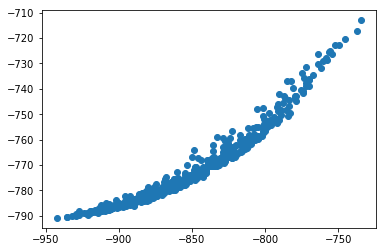

In [128]:
%matplotlib inline
from pylab import *
plt.plot(rewards[:,0], rewards[:,1], 'o')

### Test  reward correlations from full runs

In [129]:
policy_parameters = []
rewards = []
timesteps = 5
for i in range(100):
    params = sample_and_set_policy_parameters(policy)
    policy_parameters.append(params)
    policy_func = lambda x: policy(mx.nd.expand_dims(mx.nd.array(x, dtype='float64'), axis=0)).asnumpy()[0]
    true_rewards, states, actions = run_one_episode(env, policy_func,
                                                    initial_state=INITIAL_GYM_STATE,
                                                    max_steps=timesteps, render=False)
#     print("True states:", states)
    our_costs, _ = run_policy(policy, cost, model, infr, 
                    static_state_generator, 100,
                    learning_rate=1e-2, num_time_steps=timesteps, 
                    num_samples=10, verbose=True)
    our_costs = -our_costs / 10.
    print("Rewards: ", true_rewards, our_costs.asnumpy())
    rewards.append(np.array([true_rewards, our_costs.asnumpy()]))
rewards = np.array(rewards)

Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.48817308]
Episode finished after 5 timesteps
Rewards:  -37.64010614804278 [-113.31582421]
Episode finished after 5 timesteps
Rewards:  -38.75810246558277 [-112.4904733]
Episode finished after 5 timesteps
Rewards:  -38.75957265880641 [-112.552286]
Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.47555275]
Episode finished after 5 timesteps
Rewards:  -38.75957265880641 [-112.55687886]
Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.48949317]
Episode finished after 5 timesteps
Rewards: 

/Users/erimeiss/workspace/pilco/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


 -37.64001939095893 [-113.39163883]
Episode finished after 5 timesteps
Rewards:  -38.75957265880641 [-112.54550566]
Episode finished after 5 timesteps
Rewards:  -38.759572658806356 [-112.55806508]
Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.48026782]
Episode finished after 5 timesteps
Rewards:  -37.91578144588073 [-113.3700815]
Episode finished after 5 timesteps
Rewards:  -38.75957265880641 [-112.55478247]
Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.49000675]
Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.49120483]
Episode finished after 5 timesteps
Rewards:  -38.75957265880641 [-112.55412453]
Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.49787719]
Episode finished after 5 timesteps
Rewards:  -37.637786790474436 [-113.4997514]
Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.48594681]
Episode finished after 5 timesteps
Rewards:  -37.63778679047443 [-113.48925192]
Epis

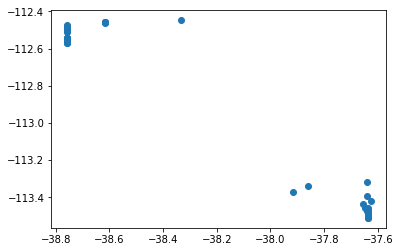

In [130]:
%matplotlib inline
from pylab import *
plt.plot(rewards[:,0], rewards[:,1], 'o')

In [155]:
policy[2].epsilon = 0.1

In [ ]:
all_states = []
all_actions = []

num_episode = 10

num_grad_steps = 100
num_time_steps = 100
learning_rate = 1e-3
use_random_policy = False
policies = []

for i_ep in range(num_episode):
    print('Start Episode '+str(i_ep+1)+'.')
    
    # Run an episode and collect data.    
    if i_ep==0 and use_random_policy:
        print("Using random policy")
        policy_func = random_policy       
#         learning_rate = 1e-2
    else:
        print("Using learned policy")
        policy_func = lambda x: policy(mx.nd.expand_dims(mx.nd.array(x, dtype='float64'), axis=0)).asnumpy()[0]
#         learning_rate = 1e-2
    total_reward, states, actions = run_one_episode(env, policy_func, initial_state=INITIAL_GYM_STATE, max_steps=num_time_steps, render=True)
    print("Actions:", actions[:5], actions[-5:])
    all_states.append(states)
    all_actions.append(actions)
    
    # Fit a model.
#     print('Fit the model.')
#     model, infr = fit_model(all_states, all_actions, win_in=1, verbose=False)
        
    # Optimize the policy.
    print('Optimize the policy.')
    policy = optimize_policy(policy, cost, model,
                             infr,
                             initial_state_generator,
                             num_grad_steps=num_grad_steps, 
                             num_samples=num_samples,
                             learning_rate=learning_rate,
                             num_time_steps=num_time_steps)
#     datum = (policy.collect_params()['dense0_weight'].data().asnumpy(),
#              policy.collect_params()['dense0_bias'].data().asnumpy())
#     policies.append(datum)

Start Episode 1.
Using learned policy
Episode finished after 100 timesteps because Max timesteps reached
Actions: [[1.43414124]
 [1.55010769]
 [1.4828283 ]
 [1.68997039]
 [1.7320114 ]] [[-0.64508136]
 [-0.37004833]
 [ 0.10650045]
 [ 0.56548208]
 [ 0.93168059]]
Optimize the policy.


/Users/erimeiss/workspace/pilco/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


Iteration 11 loss: 9502.8702533147269
Parameter dense10_weight (shape=(50, 3), dtype=float64) 
[[ 2.08468611e+02 -3.71355335e+02  6.36010330e+03]
 [ 2.83523680e+01 -3.76627576e+01  2.54355441e+02]
 [ 6.93438560e+02 -6.22250478e+02  7.07144385e+03]
 [ 4.01865369e+01 -2.36790450e+02  3.96344640e+03]
 [-1.19107655e+03  1.14558621e+03 -2.05074502e+04]
 [-6.56350241e+01 -3.34430077e+02  6.36306435e+03]
 [ 2.25600868e+02 -7.81776027e+02  1.22859823e+04]
 [ 3.44303388e+01 -2.61578151e+02  3.88415032e+03]
 [-1.15644909e+03  6.26196284e+02 -1.19778771e+04]
 [-9.30314862e+02  1.15671148e+03 -1.29314844e+04]
 [-3.92141649e+02  4.71923894e+01 -4.68355847e+03]
 [ 5.05193057e+02 -9.94338861e+02  2.20323825e+04]
 [-9.94533858e+00  1.00811797e+02 -1.38602249e+03]
 [ 2.77438189e+02 -3.98126189e+02  6.91372655e+03]
 [-1.45923440e+01  1.96232019e+02 -2.21065655e+03]
 [ 2.44078265e+02 -1.40669387e+03  2.14638108e+04]
 [-3.28262591e+02  9.60654288e+02 -1.49142087e+04]
 [-1.43159872e+03  1.63618141e+03 -1.9

In [ ]:
plt.plot(policies2)

In [ ]:
policy.collect_params()

1. update the optimize policy fuction.
2. multiple initial states.
3. use the real reward function. (https://github.com/openai/gym/blob/master/gym/envs/classic_control/continuous_mountain_car.py)
4. visualize the intermediate and final performance of policy.
5. Make a notebook to show.
6. Try a non-linear policy.
7. add epsilon-greedy policy

In [ ]:
env.env.state

In [ ]:
env.render()

In [ ]:
-env.env.state[0]

In [ ]:
np.sin(-env.env.state[0])

In [ ]:
np.cos(all_states[1][-1][0])



In [ ]:
debug

In [ ]:
all_actions

In [157]:
parameters1 = run_one_episode(env, policy_func, max_steps=1000, render=True)

Episode finished after 1000 timesteps because Max timesteps reached


In [144]:
parameters1[2]

array([[-0.00410415],
       [-0.72528974],
       [ 1.24832118],
       [ 0.8772028 ],
       [-0.32302655],
       [-0.01789244],
       [ 0.3494334 ],
       [ 0.72145449],
       [ 1.03788306],
       [ 1.26193728],
       [ 1.36199073],
       [ 1.38161457],
       [ 1.31819183],
       [ 1.19272008],
       [ 1.70261263],
       [ 0.90725467],
       [ 0.82835533],
       [ 1.62001097],
       [ 0.79981702],
       [ 0.96531963],
       [ 1.21223956],
       [ 1.34604671],
       [ 1.40050747],
       [ 1.42789314],
       [ 1.44513747],
       [ 1.40288608],
       [-1.60074856],
       [ 1.1367677 ],
       [ 0.83197998],
       [ 0.39185506],
       [-0.09702097],
       [-0.65135803],
       [-0.4156784 ],
       [-1.20885281],
       [-1.32268645],
       [-1.33442566],
       [-0.91926375],
       [-1.13286517],
       [-0.94070886],
       [-0.72796598],
       [-0.58153005],
       [-0.44438442],
       [-0.36816953],
       [-0.41145074],
       [-1.26623371],
       [-1

In [ ]:
policy[0].collect_params()['dense0_weight'].set_data(mx.nd.array([[-2.26582996, -4.80595503]], dtype='float64'))
policy[0].collect_params()['dense0_bias'].set_data(mx.nd.array([1.73686036], dtype='float64'))

In [ ]:
parameters1 = run_one_episode(env, policy_func, max_steps=10000, render=True)